# set variables

In [11]:
IMAGE_SIZE = 768
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# set dataset


In [12]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"colon cancer photos",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.


In [13]:
class_names = dataset.class_names
class_names

['colon_aca', 'colon_n']

In [14]:
len(dataset)

63

In [15]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 768, 768, 3)
[0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0]


# #show a particuler image array data

In [16]:


for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[146. 122. 216.]
  [153. 130. 221.]
  [166. 140. 229.]
  ...
  [174. 132. 232.]
  [170. 129. 233.]
  [166. 125. 229.]]

 [[151. 127. 221.]
  [156. 133. 224.]
  [166. 142. 230.]
  ...
  [173. 131. 231.]
  [169. 128. 232.]
  [165. 124. 228.]]

 [[154. 130. 226.]
  [159. 135. 229.]
  [167. 142. 233.]
  ...
  [174. 132. 232.]
  [168. 127. 231.]
  [164. 123. 227.]]

 ...

 [[226. 201. 240.]
  [226. 201. 240.]
  [227. 199. 239.]
  ...
  [209. 168. 234.]
  [206. 166. 229.]
  [204. 164. 227.]]

 [[227. 202. 242.]
  [225. 200. 240.]
  [226. 198. 239.]
  ...
  [209. 169. 232.]
  [206. 166. 229.]
  [204. 164. 227.]]

 [[227. 202. 242.]
  [225. 200. 240.]
  [226. 197. 241.]
  ...
  [209. 169. 232.]
  [206. 166. 229.]
  [204. 164. 227.]]]


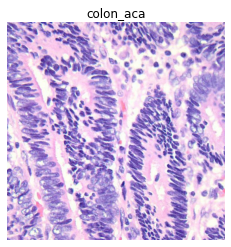

In [17]:
#show the image

for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
   

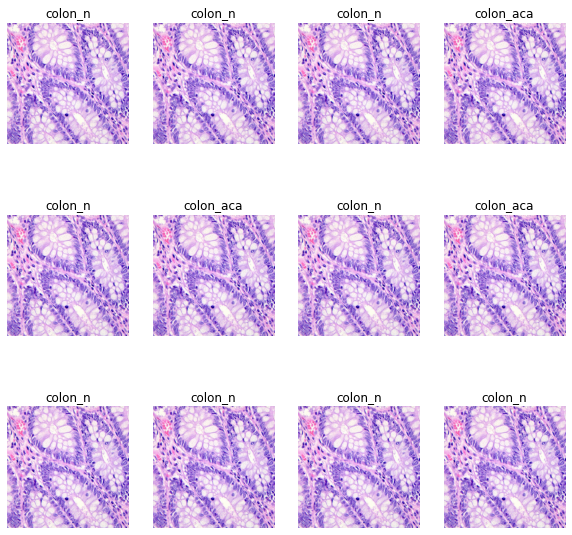

In [18]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# train+validation+test

In [19]:
#train+validation+test
# 80% ==> training
#20% ==> 10% validation,10% test

In [20]:
train_size = 0.8
len(dataset)*train_size

50.400000000000006

In [21]:
train_ds = dataset.take(50)
len(train_ds)

50

In [22]:
#test dataset separation

test_ds = dataset.skip(50)

In [23]:
len(test_ds)

13

In [24]:
#validation dataset separation

In [25]:
val_size = 0.1
len(dataset)*val_size

6.300000000000001

In [26]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [27]:
#test data
test_ds = test_ds.skip(6)
len(test_ds)

7

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:


len(train_ds)

50

In [31]:

len(train_ds)

50

In [32]:
len(val_ds)


6

In [28]:

len(test_ds)

7

In [ ]:
#cache,shuffle,prefetch

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# model building

In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# data augmentation


In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


# applying CNN


In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [2]:

model.summary()

NameError: name 'model' is not defined

# Compiling the Model

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [1]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

NameError: name 'model' is not defined